# [E-11] 삼성전자 주식 예측하기

<br>

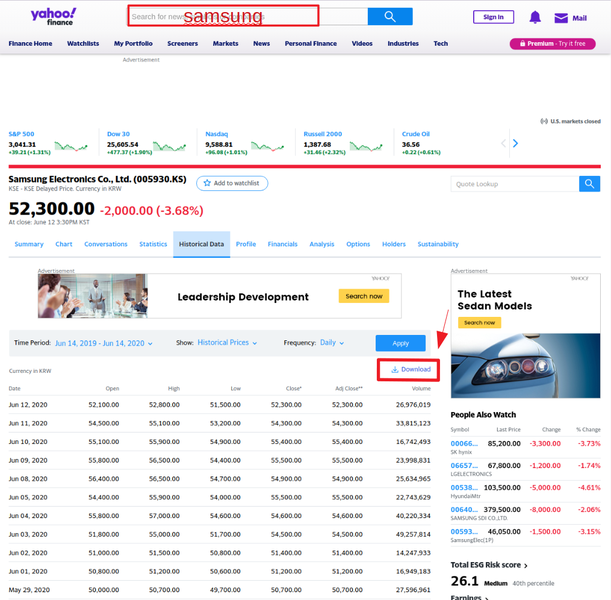

<br>


그림과 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 오늘 사용할 데이터셋을 다운로드

### **STEP 1 : 시계열 데이터 준비**

---

- **칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume**
- **날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인가능**
- **우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능, 종가란 하루의 장이 마감하였을 때의 가격)**

In [1]:
# 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.0,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.0,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.0,16450920
2021-05-17,80800.0,80900.0,79200.0,79600.0,79600.0,17740855
2021-05-18,79600.0,80000.0,79100.0,79600.0,79600.0,17265868


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [5]:
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### **STEP 2 : 각종 전처리 수행**

---

- **결측치 처리** - 데이터 보간 방법 : 시간
- **로그 변환**

In [6]:
# 결측치 처리 - 시간으로 보간함 
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [7]:
# 로그 변환 시도 
ts_log = np.log(ts)

### **STEP 3 : 시계열 안정성 분석**

---

- **정성적 그래프 분석**
- **정량적 Augmented Dicky-Fuller Test**
- **시계열 분해(Time Series Decomposition)**
- **Residual 안정성 확인**

### 3.1 정성적 그래프 분석

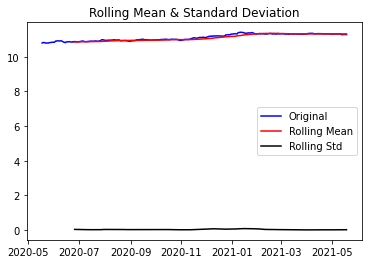

In [8]:
# 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 정의
def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=30)

### 3.2 정량적 Augmented Dicky-Fuller Test

In [9]:
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 3.3 시계열 분해(Time Series Decomposition)

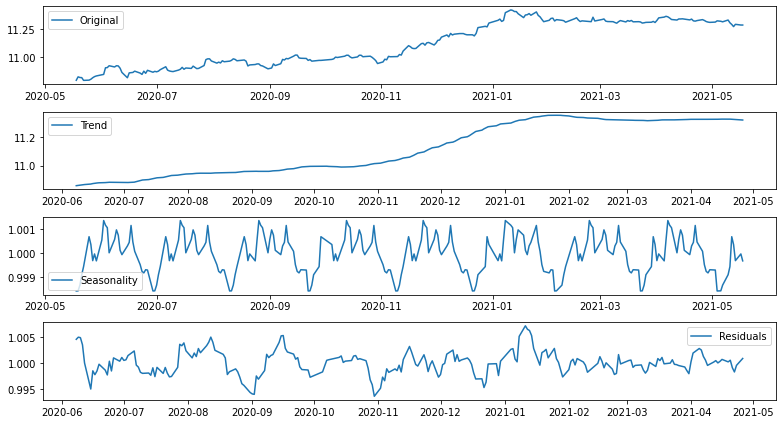

In [10]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인

In [11]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### **STEP 4 : 학습, 테스트 데이터셋 생성**

---

- **학습, 테스트 데이터셋 분리 & 시각화**

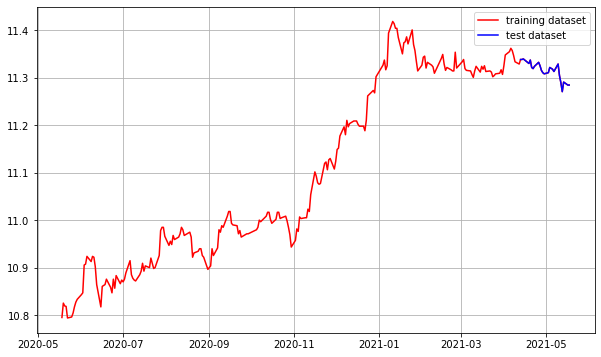

In [12]:
# 학습, 테스트 데이터셋 분리 & 시각화
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### **STEP 5 : 적정 ARIMA Parameter 찾기**

---
**ARIMA의 Parameter 3가지**

- **p** **: 자기회귀 모형(AR)의 시차**
- **d** **: 차분 누적(I) 횟수**
- **q : 이동평균 모형(MA)의 시차**



### 5.1 ACF, PACF 시각화 -> p,q 구하기

**ACF(Autocorrelation Function)**

- **시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수**
- **주어진 시계열의 현재 값이 과거 $(y_{t-1}, y_{t-2}, ...., y_{t-n})$값과 어떻게 상관되는지 설명**
- **ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄**

<br><br>
**PACF(Partial Autocorrelation Function)**

- **다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수**
- **특정 두 관측치,  $y_{t}$와  $y_{t-k}$가 얼마나 관련이 있는지 나타내는 척도.**

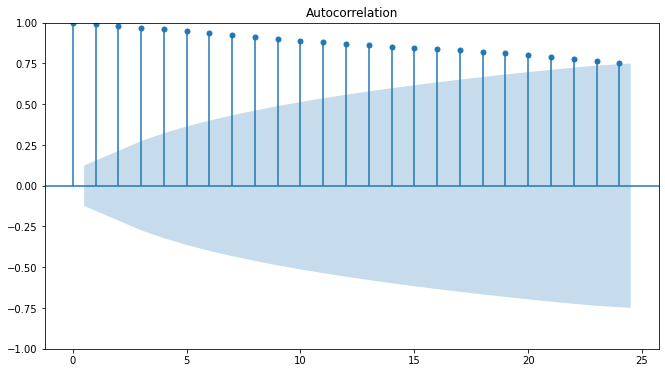

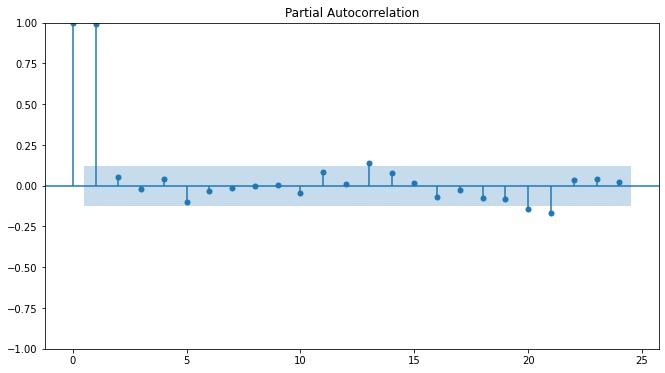

In [13]:
# ACF, PACF 시각화 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 5.2 차분

- **차분 : 정상화를 위해 시계열 데이터에 적용되는 변환**
   - **데이터를 차분하기 위해 연속 관측치의 차를 계산**
   - **$y_{t}'=y_{t}-y_{t-1}$**
   - **시계열 수준의 변화를 제거하여 추세와 계절성을 제거하고 결과적으로 시계열의 평균을 안정화**

### 5.2.1 1차  차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


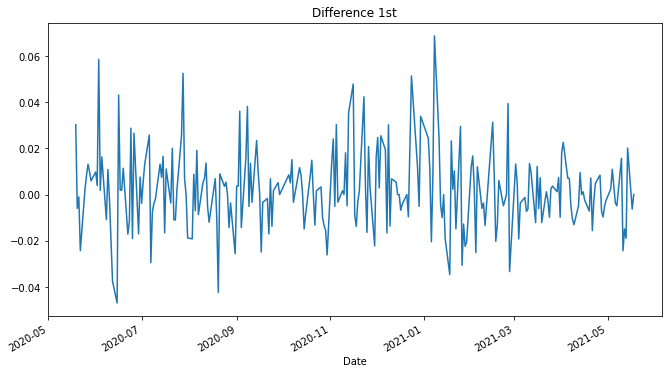

In [14]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 5.2.2 2차 차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


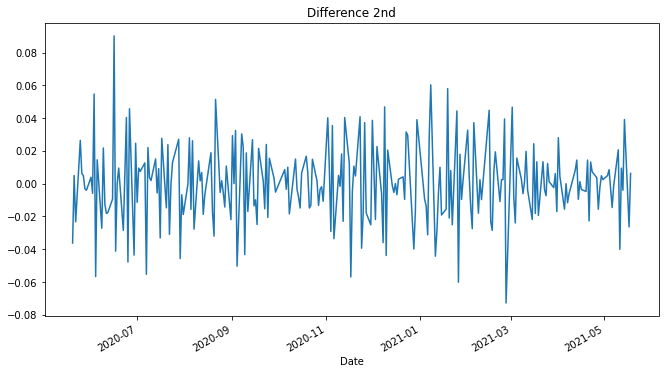

In [15]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### **STEP 6 : ARIMA 모델 훈련과 테스트**

---

- **ARIMA 모델 생성, 훈련**
- **모델 테스트 및 시각화**
- **최종 예측 모델 정확도 측정(MAPE)**

### 6.1 ARIMA 모델 생성, 훈련

In [16]:
# ARIMA 모델 생성, 훈련
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Wed, 16 Feb 2022   AIC                          -1156.722
Time:                        12:39:55   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 6.2 모델 테스트 및 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


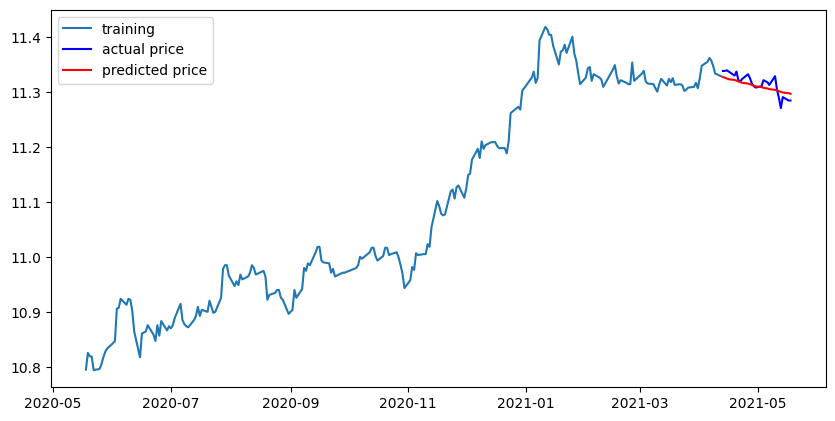

In [17]:
# 모델 테스트 및 시각화
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [18]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


### Step 7 다른 주식 종목 예측해 보기

### 7.1 스타벅스 주식 예측하기

### **STEP 1 : 시계열 데이터 준비**

In [1]:
# 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SBUX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-09,96.250000,97.970001,96.199997,97.129997,96.639999,9353700
2022-02-10,95.459999,96.809998,94.980003,95.309998,95.309998,9098800
2022-02-11,95.589996,96.489998,93.360001,93.730003,93.730003,6922200
2022-02-14,93.750000,94.489998,92.419998,93.650002,93.650002,7947200
2022-02-15,95.150002,95.459999,94.360001,94.510002,94.510002,7722200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2021-02-16 to 2022-02-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       254 non-null    float64
 1   High       254 non-null    float64
 2   Low        254 non-null    float64
 3   Close      254 non-null    float64
 4   Adj Close  254 non-null    float64
 5   Volume     254 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.9 KB


In [4]:
ts = df['Close']

ts.head()

Date
2021-02-16    106.150002
2021-02-17    104.440002
2021-02-18    104.970001
2021-02-19    103.370003
2021-02-22    101.809998
Name: Close, dtype: float64

### **STEP 2 : 각종 전처리 수행**

In [5]:
# 결측치 처리 - 시간으로 보간함 
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

### **STEP 3 : 시계열 안정성 분석**

### 3.1 정성적 그래프 분석

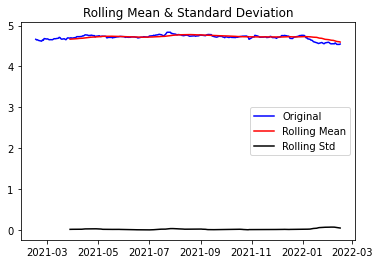

In [7]:
# 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 정의
def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=30)

### 3.2 정량적 Augmented Dicky-Fuller Test

In [8]:
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.934516
p-value                          0.776393
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


### 3.3 시계열 분해(Time Series Decomposition)

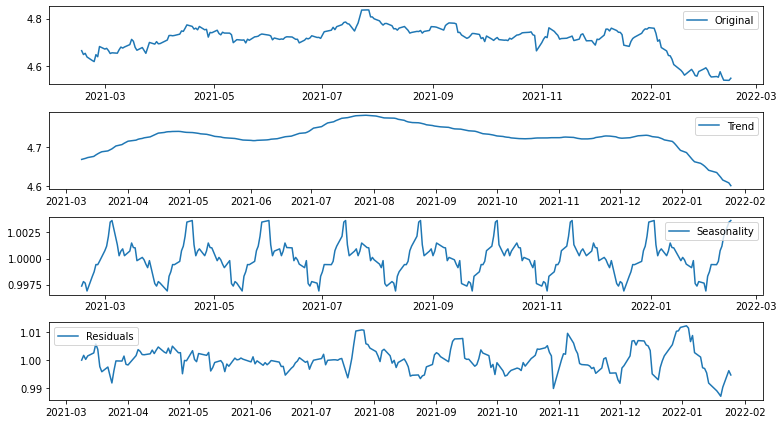

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.467777
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


### **STEP 4 : 학습, 테스트 데이터셋 생성**

---

- **학습, 테스트 데이터셋 분리 & 시각화**

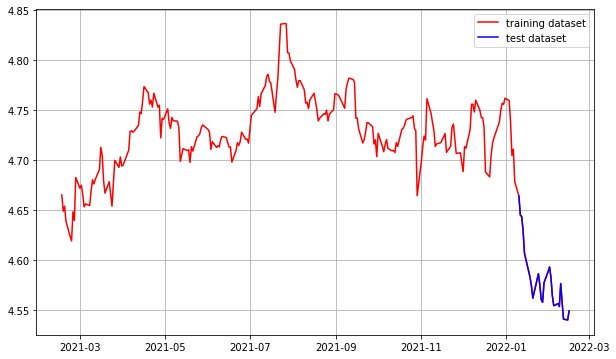

In [11]:
# 학습, 테스트 데이터셋 분리 & 시각화
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5.1 ACF, PACF 시각화 

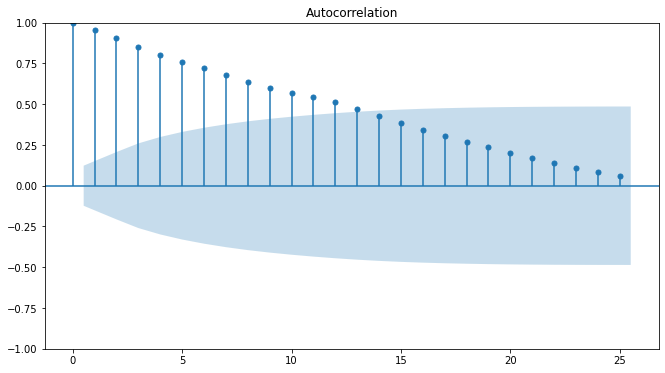

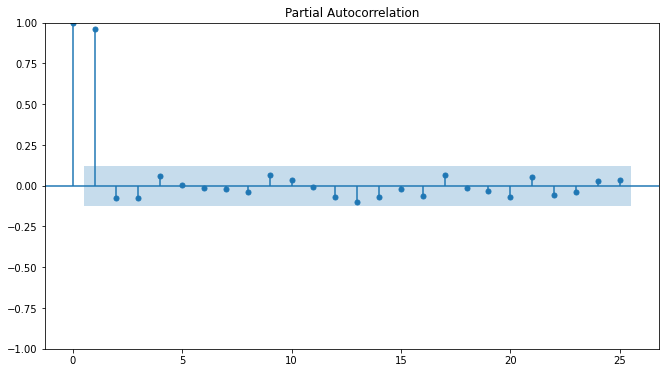

In [12]:
# ACF, PACF 시각화 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 5.2.1 1차  차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -1.548132e+01
p-value                        2.553988e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


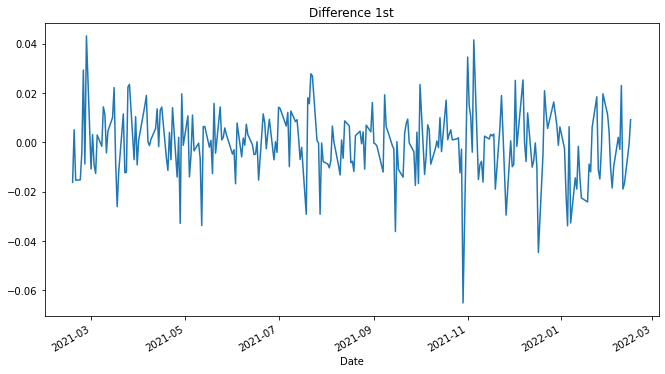

In [13]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 5.2.2 2차 차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -8.021743e+00
p-value                        2.067509e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


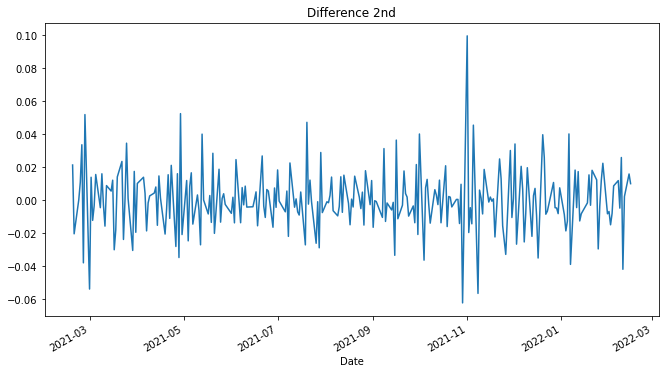

In [14]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 6.1 ARIMA 모델 생성, 훈련

In [15]:
# ARIMA 모델 생성, 훈련
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 656.883
Date:                Wed, 16 Feb 2022   AIC                          -1303.765
Time:                        12:43:35   BIC                          -1286.619
Sample:                             0   HQIC                         -1296.847
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7215      0.013    361.754      0.000       4.696       4.747
ar.L1          0.1107      0.304      0.364      0.716      -0.486       0.707
ar.L2          0.7780      0.281      2.770      0.0

### 6.2 모델 테스트 및 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


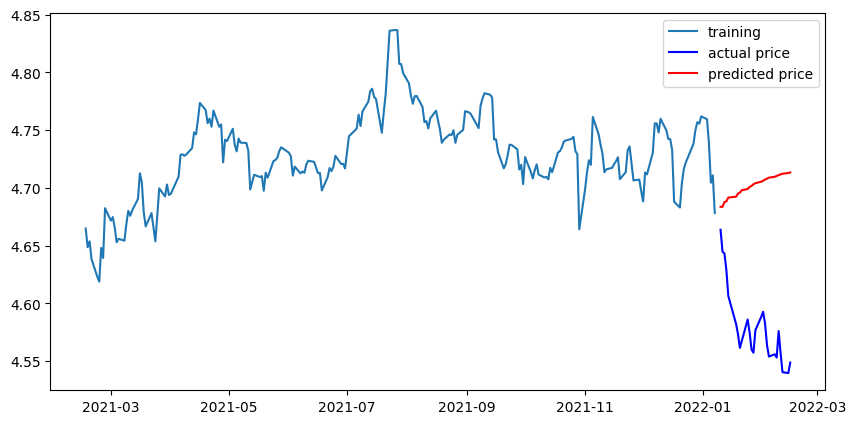

In [16]:
# 모델 테스트 및 시각화
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [17]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  174.6649622677068
MAE:  12.568119279856004
RMSE:  13.216087252576187
MAPE: 13.03%


### 7.2  APPLE 주식 예측하기

### **STEP 1 : 시계열 데이터 준비**

In [1]:
# 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-09,176.050003,176.649994,174.899994,176.279999,176.279999,71285000
2022-02-10,174.139999,175.479996,171.550003,172.119995,172.119995,90865900
2022-02-11,172.330002,173.080002,168.039993,168.639999,168.639999,98566000
2022-02-14,167.369995,169.580002,166.559998,168.880005,168.880005,86062800
2022-02-15,170.970001,172.949997,170.250000,172.789993,172.789993,62527400


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2021-02-16 to 2022-02-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       254 non-null    float64
 1   High       254 non-null    float64
 2   Low        254 non-null    float64
 3   Close      254 non-null    float64
 4   Adj Close  254 non-null    float64
 5   Volume     254 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.9 KB


In [4]:
ts = df['Close']

ts.head()

Date
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
Name: Close, dtype: float64

### **STEP 2 : 각종 전처리 수행**

In [5]:
# 결측치 처리 - 시간으로 보간함 
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

### **STEP 3 : 시계열 안정성 분석**

### 3.1 정성적 그래프 분석

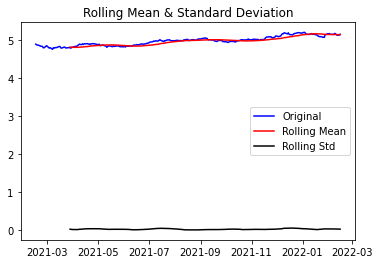

In [7]:
# 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 정의
def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=30)

### 3.2 정량적 Augmented Dicky-Fuller Test

In [8]:
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.623488
p-value                          0.865586
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


### 3.3 시계열 분해(Time Series Decomposition)

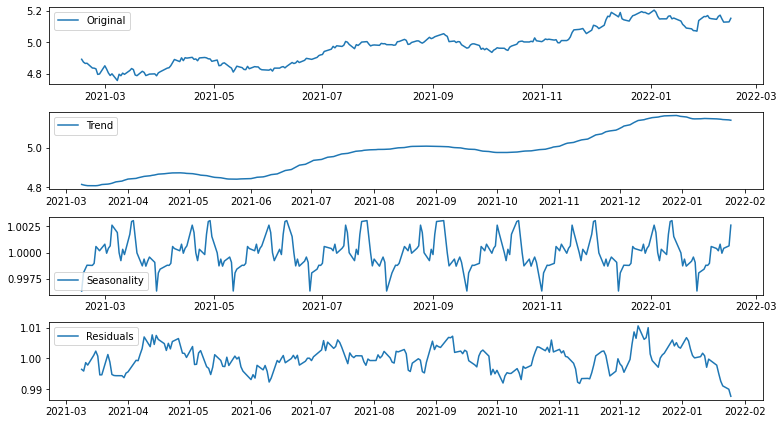

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.201653
p-value                          0.000655
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


### **STEP 4 : 학습, 테스트 데이터셋 생성**

---

- **학습, 테스트 데이터셋 분리 & 시각화**

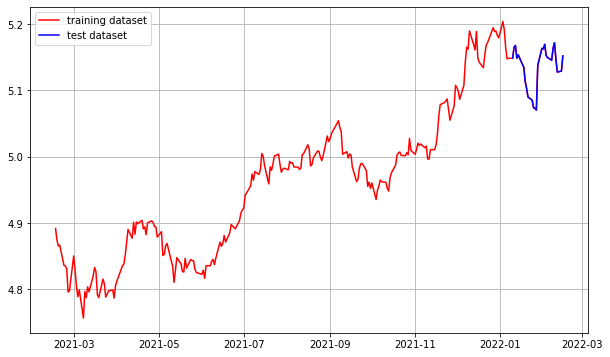

In [11]:
# 학습, 테스트 데이터셋 분리 & 시각화
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5.1 ACF, PACF 시각화 

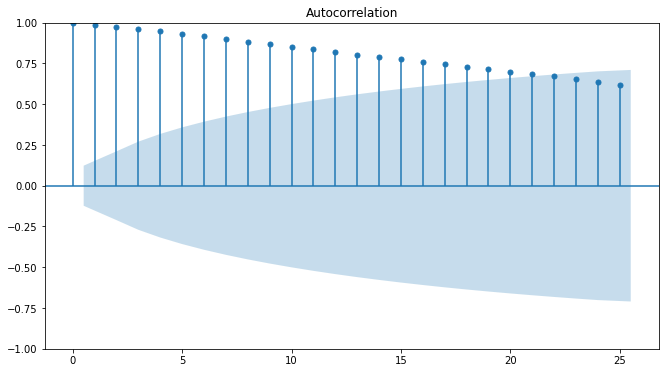

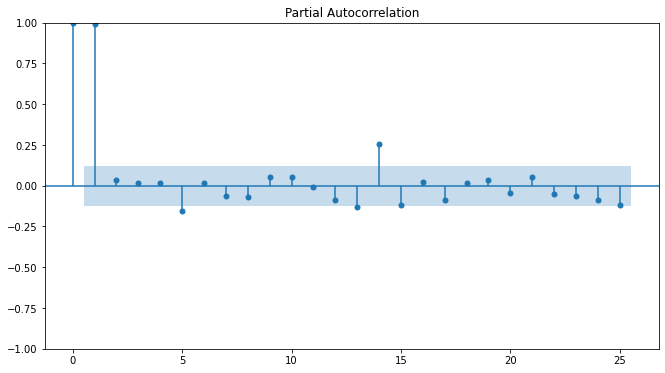

In [12]:
# ACF, PACF 시각화 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 5.2.1 1차  차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -1.025587e+01
p-value                        4.362888e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


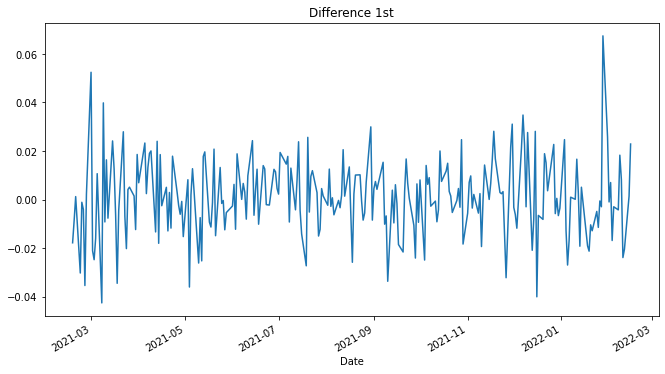

In [13]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 5.2.2 2차 차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -7.684706e+00
p-value                        1.472111e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


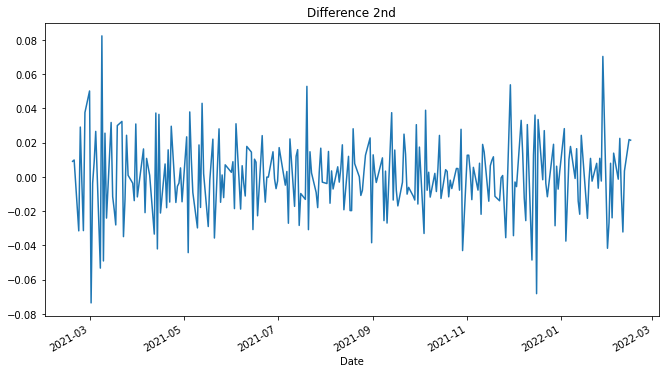

In [14]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 6.1 ARIMA 모델 생성, 훈련

In [15]:
# ARIMA 모델 생성, 훈련
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 628.360
Date:                Wed, 16 Feb 2022   AIC                          -1246.719
Time:                        12:46:00   BIC                          -1229.573
Sample:                             0   HQIC                         -1239.801
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9544      0.379     13.077      0.000       4.212       5.697
ar.L1          1.4632      0.633      2.310      0.021       0.222       2.705
ar.L2         -0.4644      0.632     -0.735      0.4

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

### 6.2 모델 테스트 및 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


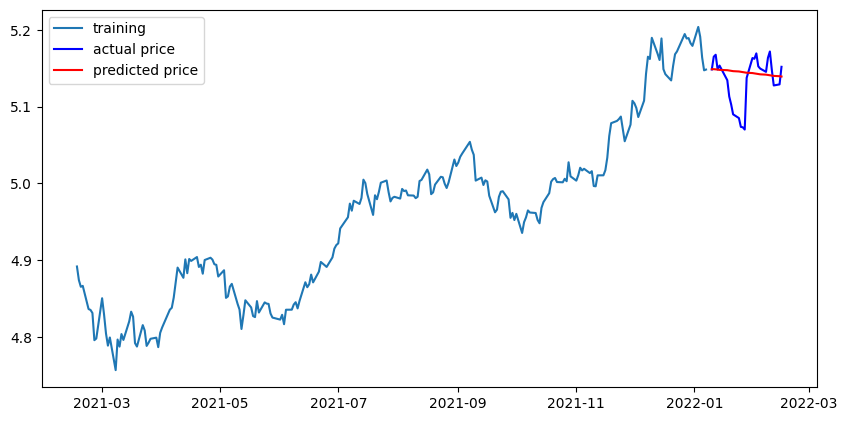

In [16]:
# 모델 테스트 및 시각화
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [17]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  32.5294877917603
MAE:  4.26387096202147
RMSE:  5.703462789548144
MAPE: 2.57%


### 7.3 테슬라 주식 예측하기

### **STEP 1 : 시계열 데이터 준비**

In [1]:
# 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-09,935.000000,946.270020,920.000000,932.000000,932.000000,17419800
2022-02-10,908.369995,943.809998,896.700012,904.549988,904.549988,22042300
2022-02-11,909.630005,915.960022,850.700012,860.000000,860.000000,26492700
2022-02-14,861.570007,898.880005,853.150024,875.760010,875.760010,22515100
2022-02-15,900.000000,923.000000,893.380005,922.429993,922.429993,19095400


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2021-02-16 to 2022-02-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       254 non-null    float64
 1   High       254 non-null    float64
 2   Low        254 non-null    float64
 3   Close      254 non-null    float64
 4   Adj Close  254 non-null    float64
 5   Volume     254 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.9 KB


In [4]:
ts = df['Close']

ts.head()

Date
2021-02-16    796.219971
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
Name: Close, dtype: float64

### **STEP 2 : 각종 전처리 수행**

In [5]:
# 결측치 처리 - 시간으로 보간함 
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

### **STEP 3 : 시계열 안정성 분석**

### 3.1 정성적 그래프 분석

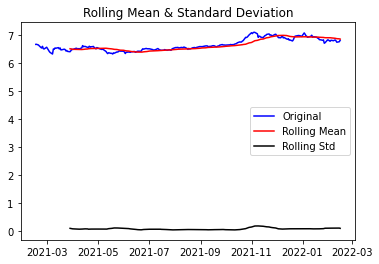

In [7]:
# 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 정의
def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=30)

### 3.2 정량적 Augmented Dicky-Fuller Test

In [8]:
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.255067
p-value                          0.649470
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


### 3.3 시계열 분해(Time Series Decomposition)

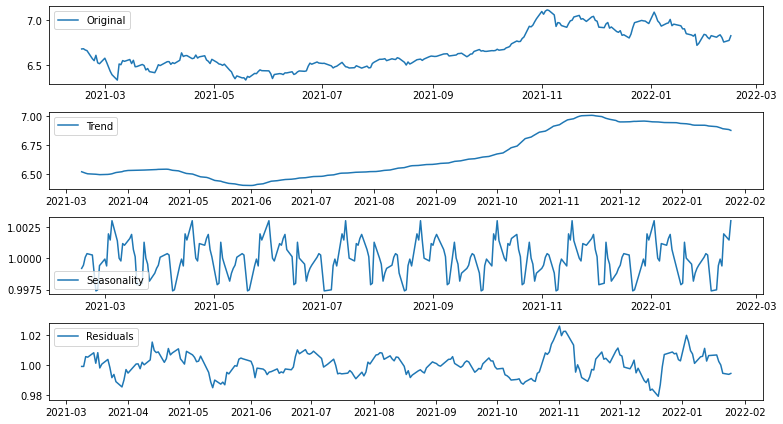

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.568763e+00
p-value                        8.034281e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


### **STEP 4 : 학습, 테스트 데이터셋 생성**

---

- **학습, 테스트 데이터셋 분리 & 시각화**

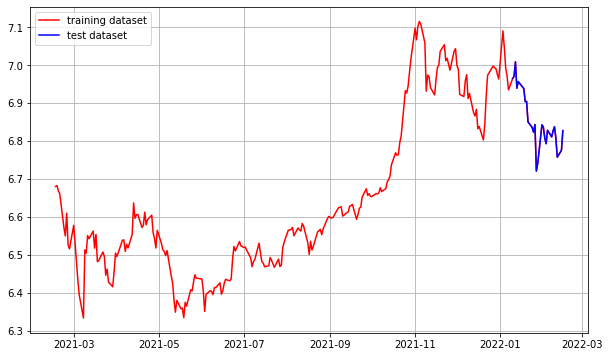

In [11]:
# 학습, 테스트 데이터셋 분리 & 시각화
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5.1 ACF, PACF 시각화 

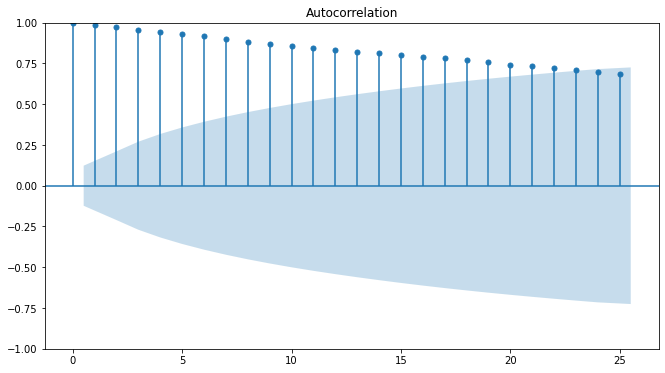

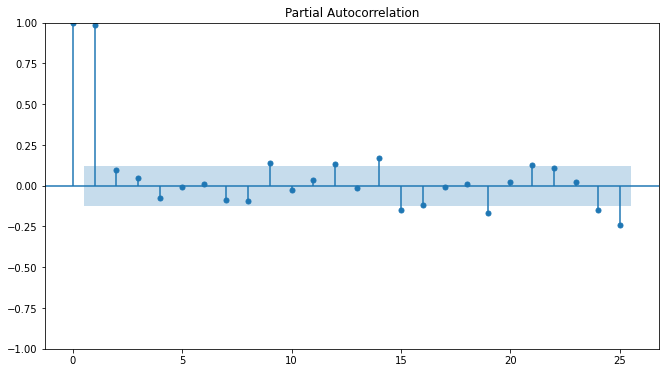

In [12]:
# ACF, PACF 시각화 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 5.2.1 1차  차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -1.676974e+01
p-value                        1.289868e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


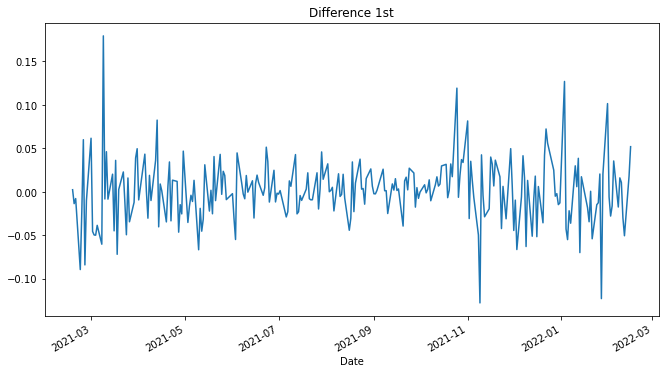

In [13]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 5.2.2 2차 차분 구하기 & 그래프 그리기

Results of Dickey-Fuller Test:
Test Statistic                -7.076177e+00
p-value                        4.795546e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


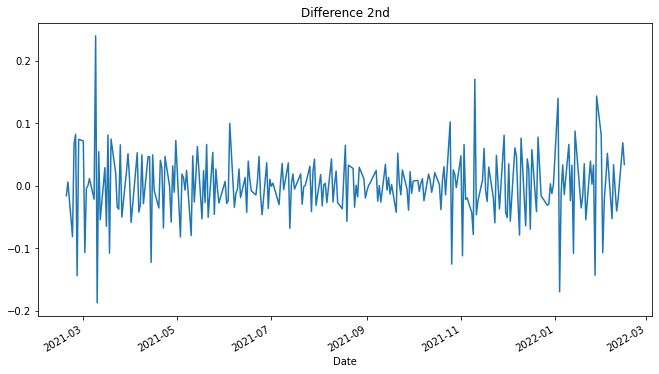

In [14]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 6.1 ARIMA 모델 생성, 훈련

In [15]:
# ARIMA 모델 생성, 훈련
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 440.326
Date:                Wed, 16 Feb 2022   AIC                           -870.651
Time:                        12:52:23   BIC                           -853.504
Sample:                             0   HQIC                          -863.733
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7005      0.160     41.940      0.000       6.387       7.014
ar.L1          0.5239      1.474      0.355      0.722      -2.366       3.413
ar.L2          0.4548      1.450      0.314      0.7

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 6.2 모델 테스트 및 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


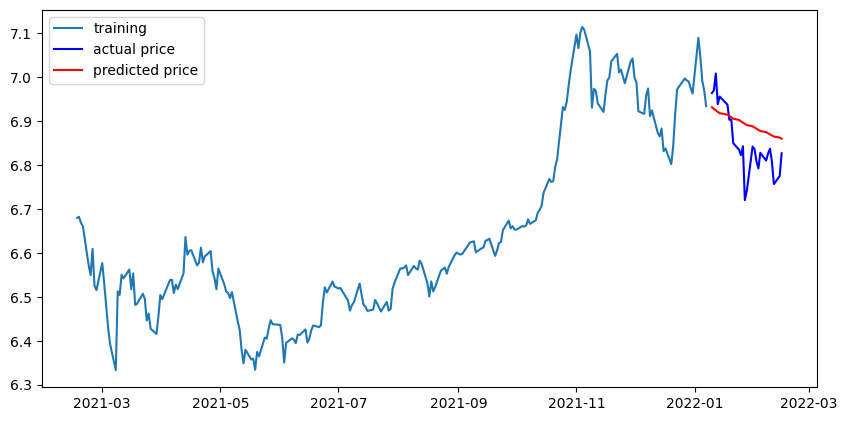

In [16]:
# 모델 테스트 및 시각화
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [17]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4501.636896460724
MAE:  57.317457867102966
RMSE:  67.09423892154022
MAPE: 6.25%


# 회고

1. 미래를 예측하기 위한 하나의 방법을 배웠다.
2. 통계 용어가 어지럽다...
3. 노드에서 열심히 했는 데, 뒤에 statsmodels패키지로 해결된다고... 아~ 허탈~~
4. 주식의 주기는 얼마가 맞나?? 찾아보니 period=30으로 해서 모델을 훈련.. 
5. 예측이 하락을 나타내면 실제처럼 급격하지 않고 조금 얌전하게 그래프가 하향되는 것 같다.
6. 현실은 만만치 않다.

### 알아낸 점
1. 미래를 예측하는 건 쉽지 않다.
2. statsmodels패키지는 통계쪽에서는 매우 많이 사용하고 오래되었다고 하던데...
3. 주식예측을 하기 위해서는 종가를 가지고 Series데이터셋 형태로 만들어야 한다..
4. 귀무가설, 대립가설, p-value

### 아직 모호한 것
- 경고문을 떠서 해결하려고 했는데 .. 구글링을 잘못했는 지.. 그래프가 안그려져서 포기..
- 통계용어는 아직 어렵다..

### 👏👏👏 모두들 수고하셨습니다.